In [13]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:

data = pd.read_csv('../../00 DATA/train.csv', sep = ',')


In [15]:
# Drop PassengerId, Name, Ticket and Cabin columns
data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [16]:
# Missing data

missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending = False)
missing

Age         177
Embarked      2
dtype: int64

In [17]:
# Drop rows with missing Embarked values

print("Before: ", data.shape)
data = data.loc[data['Embarked'].notnull(), :]
print("After: ", data.shape)

Before:  (891, 8)
After:  (889, 8)


In [18]:
data['Sex'] = data['Sex'].map({'male': 1, 'female': 0})
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


Text(0.5, 1.0, 'Correlation between features')

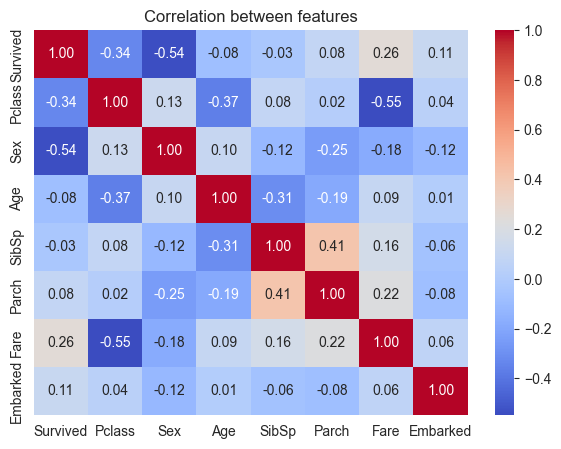

In [19]:
# Plot heatmap

correlation = data.corr()
plt.figure(figsize = (7, 5))
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation between features')

Text(0.5, 1.0, 'Passenger Age Distribution')

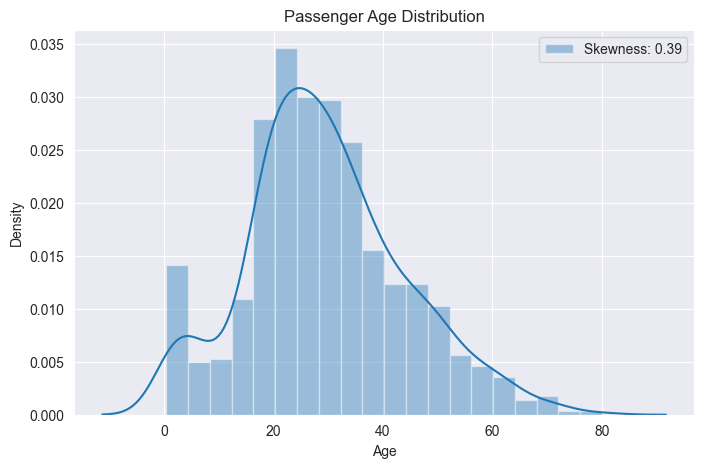

In [20]:
# Plot passenger age distribution

plt.figure(figsize = (8, 5))
sns.distplot(data['Age'], label = 'Skewness: {:.2f}'.format(data['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

In [21]:
# Age summary statistics

data['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [22]:
# Create sample dataframe

df = pd.DataFrame({'SibSp': [1, 1, 0, 1, 0, 0],
                   'Fare': [7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583],
                   'Age': [22, 38, 26, 35, 35, np.nan]})
df

,SibSp,Fare,Age
0,1,7.2500,22.0
1,1,71.2833,38.0
2,0,7.9250,26.0
3,1,53.1000,35.0
4,0,8.0500,35.0
5,0,8.4583,NaN


In [23]:
print("Average age: ", df['Age'].mean())
simple_imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
simple_imp.fit_transform(df)

Average age:  31.2


array([[ 1.    ,  7.25  , 22.    ],
       [ 1.    , 71.2833, 38.    ],
       [ 0.    ,  7.925 , 26.    ],
       [ 1.    , 53.1   , 35.    ],
       [ 0.    ,  8.05  , 35.    ],
       [ 0.    ,  8.4583, 31.2   ]])

# Iterative imputer

Iterative imputer is an example of a multivariate approach to imputation. It models the missing values in a column by using information from the other columns in a dataset. More specifically, it treats the column with missing values as a target variable while the remaining columns are used are predictor variables to predict the target variable. 

In our sample data frame, the Age column has one missing value on row 6 and is therefore assigned as the target variable in this scenario. This leaves the SibSp and Fare columns as our predictor variables. 

Iterative imputer will use the first 5 rows of the data frame to train a predictive model. Once the model is ready, it will then values in the SibSp and Fare columns of row 6 as inputs and predict the Age value for that row.

#### It is a data transform that is first configured based on the method used to estimate the missing values. By default, a BayesianRidge model is employed that uses a function of all other input features. Features are filled in ascending order, from those with the fewest missing values to those with the most.



In [24]:
# بجای میانگین گرفتن از رگرسیون برای پر کردن داده استفاده میشه

iterative_imp = IterativeImputer()
iterative_imp.fit_transform(df)

array([[ 1.        ,  7.25      , 22.        ],
       [ 1.        , 71.2833    , 38.        ],
       [ 0.        ,  7.925     , 26.        ],
       [ 1.        , 53.1       , 35.        ],
       [ 0.        ,  8.05      , 35.        ],
       [ 0.        ,  8.4583    , 28.50639495]])

# 4.3 KNN imputer

Last but not least, we have KNN Imputer which is another multivariate imputation technique. KNN Imputer scans our dataframe for k nearest observations to the row with missing value. It will then proceed to fill the missing value with the average of those nearest observations.

Here, I have set k to equal to 2 or in other words, I want KNN imputer to look for 2 observations that are nearest to row 6 and fill the missing age with the average age of those 2 rows.

In [25]:
knn_imp = KNNImputer(n_neighbors = 2)
knn_imp.fit_transform(df)

array([[ 1.    ,  7.25  , 22.    ],
       [ 1.    , 71.2833, 38.    ],
       [ 0.    ,  7.925 , 26.    ],
       [ 1.    , 53.1   , 35.    ],
       [ 0.    ,  8.05  , 35.    ],
       [ 0.    ,  8.4583, 30.5   ]])

Run in models

In [28]:
data.head()
# Get predictor and target variables

X = data.drop('Survived', axis=1)
Y = data['Survived']
# Predictor and target variables shape

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (889, 7)
Y shape:  (889,)


simple imputer

In [29]:
# Instantiate OneHotEncoder for Sex and Embarked columns
ohe = OneHotEncoder()

# Instantiate simple imputer
simple_imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Instantiate model
rf = RandomForestClassifier()

# Make column transformer with simple imputer
column_transform = make_column_transformer(
    (ohe, ['Sex', 'Embarked']),
    (simple_imp, ['Age']),
    remainder = 'passthrough')

# Pipeline
pipe = make_pipeline(column_transform, rf)

# 10-fold cross-validation
cross_val_score(pipe, X, Y, cv = 10, scoring = 'accuracy').mean()

np.float64(0.8065628192032687)

iterative imputer

In [30]:
# Instantiate OneHotEncoder for Sex and Embarked columns
ohe = OneHotEncoder()

# Instantiate iterative imputer
iterative_imp = IterativeImputer()

# Instantiate model
rf = RandomForestClassifier()

# Make column transformer with iterative imputer
column_transform = make_column_transformer(
    (ohe, ['Sex', 'Embarked']),
    (iterative_imp, ['Age']),
    remainder = 'passthrough')

# Pipeline
pipe = make_pipeline(column_transform, rf)

# 10-fold cross-validation
cross_val_score(pipe, X, Y, cv = 10, scoring = 'accuracy').mean()

np.float64(0.8166751787538304)

knn imputer

In [31]:
# Instantiate OneHotEncoder for Sex and Embarked columns
ohe = OneHotEncoder()

# Instantiate KNN imputer
KNN_imp = KNNImputer()

# KNN model
rf = RandomForestClassifier()

# Make column transformer with iterative imputer
column_transform = make_column_transformer(
    (ohe, ['Sex', 'Embarked']),
    (KNN_imp, ['Age']),
    remainder = 'passthrough')

# Pipeline
pipe = make_pipeline(column_transform, rf)

# 10-fold cross-validation
cross_val_score(pipe, X, Y, cv = 10, scoring = 'accuracy').mean()

np.float64(0.8076608784473953)